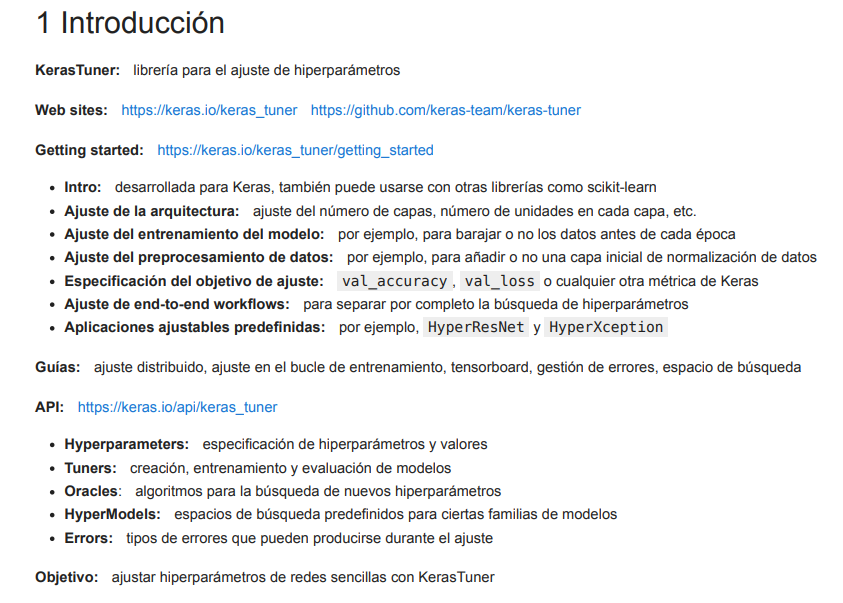

**Con esta librería se proporcionan una serie de valores entre los cuales se hace una búsqueda del más óptimo de manera automatizada para el adecuado entrenamiento de redes neuronales. Es lo que se llama ajuste de hiperparámetros.**

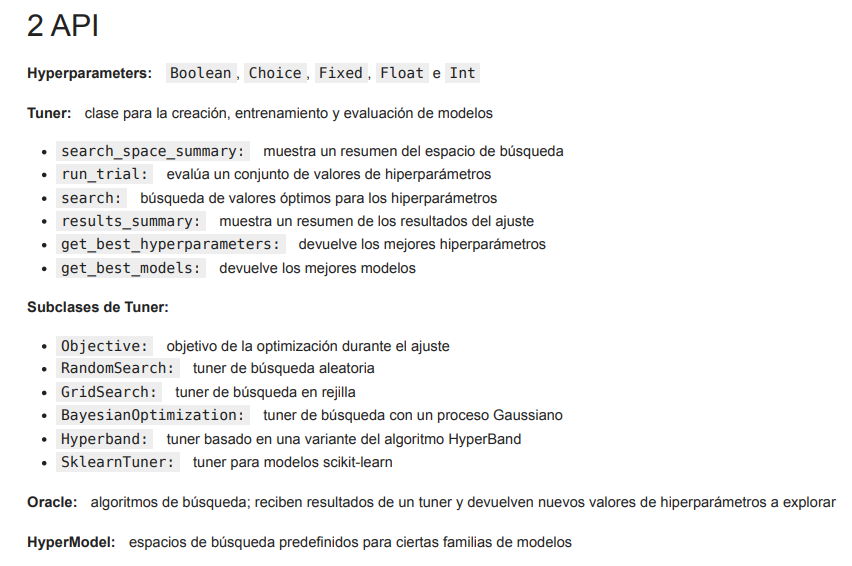

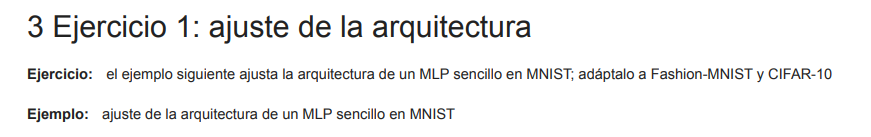

In [1]:
!pip install silence_tensorflow
!pip install keras-tuner

<h1>Búsqueda de la mejor red neuronal para MNIST con Keras Tuner<h1>

En este ejemplo se utiliza Keras Tuner con Random Search para encontrar la arquitectura óptima de una red neuronal densa que clasifica dígitos del conjunto MNIST.

Datos: Se cargan las imágenes de dígitos escritos a mano, se reescalan los píxeles a valores entre 0 y 1 y se aplastan a vectores de 784 dimensiones (28x28).

Modelo parametrizable: Se define una función que construye una red neuronal según hiperparámetros elegidos por el tuner. La red puede tener:

    1 o 2 capas ocultas

    Entre 700 y 900 neuronas por capa

    Dropout entre 0.3 y 0.6

La capa final tiene 10 salidas con activación softmax.

Tuning: Se lanza una búsqueda aleatoria de hasta 5 configuraciones diferentes, evaluando cada modelo en un subconjunto de validación (10%) con parada temprana para evitar sobreentrenamiento.

Resultado: Se selecciona el mejor modelo según precisión en validación (val_accuracy), se evalúa sobre el conjunto de test y se muestran tanto la precisión como los hiperparámetros óptimos.

Este proceso permite automatizar la elección de una arquitectura eficiente sin necesidad de ensayo y error manual.

In [9]:
import numpy as np; import matplotlib.pyplot as plt; import silence_tensorflow
import keras; import keras_tuner; keras.utils.set_random_seed(23)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28*28).astype("float32") / 255.0

def build(hp):
    M = keras.Sequential()
    M.add(keras.Input(shape=(28*28,)))
    for L in range(hp.Int("num_layers", 1, 2)):
        M.add(keras.layers.Dense(
            units=hp.Int(f"units_{L}", 700, 900, step=100),
            activation='relu'
        ))
        M.add(keras.layers.Dropout(hp.Float("dropout", 0.3, 0.6, step=0.1)))
    M.add(keras.layers.Dense(10, activation='softmax'))
    M.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return M

import time; start = time.time()
tuner = keras_tuner.RandomSearch(
    hypermodel=build,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory="./kt_dir",
    project_name="MNIST"
)

early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
tuner.search(x_train, y_train, epochs=20, validation_split=0.1, callbacks=[early_cb], verbose=1)
best_hp = tuner.get_best_hyperparameters(1)[0]
best_M = tuner.get_best_models(num_models=1)[0]
print(f'Precisión: {best_M.evaluate(x_test, y_test, verbose=0)[1]:.2%} con {best_hp.values}')
print('Tiempo (hh:mm:ss):', time.strftime('%H:%M:%S', time.gmtime(time.time() - start)))


Trial 5 Complete [00h 01m 14s]
val_accuracy: 0.9836666584014893

Best val_accuracy So Far: 0.984000027179718
Total elapsed time: 00h 05m 31s
Precisión: 98.07% con {'num_layers': 1, 'units_0': 900, 'dropout': 0.3, 'units_1': 900}
Tiempo (hh:mm:ss): 00:05:31


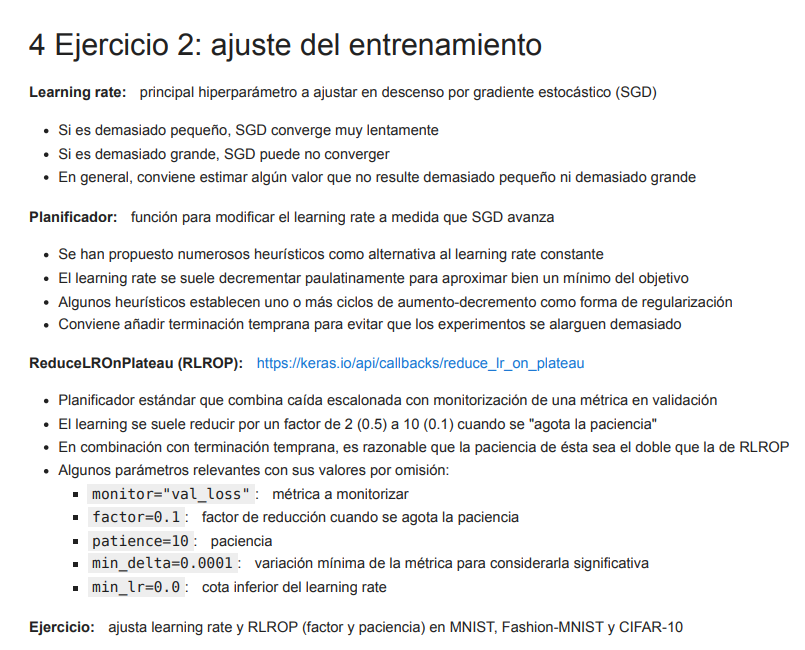

En este ejemplo se utiliza Keras Tuner con Random Search para encontrar los mejores hiperparámetros de entrenamiento para una red neuronal densa aplicada al conjunto MNIST.

Datos: Se cargan imágenes de dígitos manuscritos, se normalizan los valores de píxel entre 0 y 1 y se aplanan a vectores de 784 componentes (28x28).

Modelo fijo: La arquitectura de la red no cambia durante el tuning. Consta de:

    Una única capa oculta de 900 neuronas con activación ReLU

    Dropout con valor fijo de 0.6

    Capa de salida softmax con 10 neuronas para clasificación multiclase

Entrenamiento parametrizable: Se ajustan los hiperparámetros que afectan al proceso de entrenamiento:

    Tasa de aprendizaje (entre 1e-5 y 0.01, muestreo logarítmico)

    Factor de reducción de LR (entre 0.1 y 0.5 si no mejora la validación)

    Paciencia para reducción de LR y parada temprana (2, 5 o 10 épocas)

Tuning: Se realiza una búsqueda aleatoria con un máximo de 5 configuraciones distintas. En cada caso, el modelo se entrena hasta 100 épocas usando un 10% de los datos como validación, con callbacks automáticos para reducir la tasa de aprendizaje y detener el entrenamiento si no hay mejoras.

Este enfoque permite encontrar una configuración de entrenamiento más eficaz sin modificar la arquitectura del modelo, centrándose únicamente en cómo se entrena.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import silence_tensorflow
import keras
import keras_tuner
keras.utils.set_random_seed(23)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28 * 28).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28 * 28).astype("float32") / 255.0

class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        inputs = keras.Input(shape=(28 * 28,))
        x = keras.layers.Dense(900, activation='relu')(inputs)
        x = keras.layers.Dropout(0.6)(x)
        outputs = keras.layers.Dense(10, activation='softmax')(x)

        model = keras.Model(inputs=inputs, outputs=outputs)

        learning_rate = hp.Float("lr", min_value=1e-5, max_value=0.01, step=2, sampling="log")
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

        model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
        return model

    def fit(self, hp, model, x, y, **kwargs):
        factor = hp.Float("factor", min_value=0.1, max_value=0.5)
        patience = hp.Choice("patience", [2, 5, 10])

        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=factor,
            patience=patience
        )
        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2 * patience,
            restore_best_weights=True
        )

        kwargs['callbacks'].extend([reduce_lr, early_stop])
        return model.fit(x, y, epochs=100, validation_split=0.1, verbose=1, **kwargs)

tuner = keras_tuner.RandomSearch(
    MyHyperModel(),
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory="./kt_dir",
    project_name="MNIST"
)

tuner.search(x_train, y_train)

Trial 5 Complete [00h 02m 53s]
val_accuracy: 0.9893333315849304

Best val_accuracy So Far: 0.9898333549499512
Total elapsed time: 00h 23m 50s


In [22]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Obtener los hiperparámetros del mejor modelo
best_hp = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters

# Mostrar los valores de los hiperparámetros ajustados
print("Hiperparámetros ajustados:")
for hp_name, hp_value in best_hp.values.items():
    print(f"{hp_name}: {hp_value}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 900)               706500    
                                                                 
 dropout (Dropout)           (None, 900)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                9010      
                                                                 
Total params: 715,510
Trainable params: 715,510
Non-trainable params: 0
_________________________________________________________________
Hiperparámetros ajustados:
lr: 0.00064
factor: 0.3133591361613539
patience: 10
